Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import warnings
warnings.filterwarnings('ignore')

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# # Defining the path for train and test images
# ## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
#Import the libraries
import zipfile
import os


zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CNN_assignment.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/dataset') #Extracts the files into the /tmp folder
zip_ref.close()



In [6]:
# Input parameter
data_dir_train ='/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
# val_data_dir ='/dataset/CNN_assignment/val'
data_dir_test='/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
filepath = '/content/drive/My Drive/CNN_assignment_weights.hdf5'
nb_epochs = 50

In [7]:
# image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
# print(image_count_train)
# image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
# print(image_count_test)

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height,img_width),
    batch_size=batch_size)##todo


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height,img_width),
    batch_size=batch_size)##todo

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

{'actinic keratosis': ['/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0031922.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027254.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026848.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026149.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030142.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025957.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026040.jpg', '/dataset/Skin cancer ISIC The International Skin Imaging

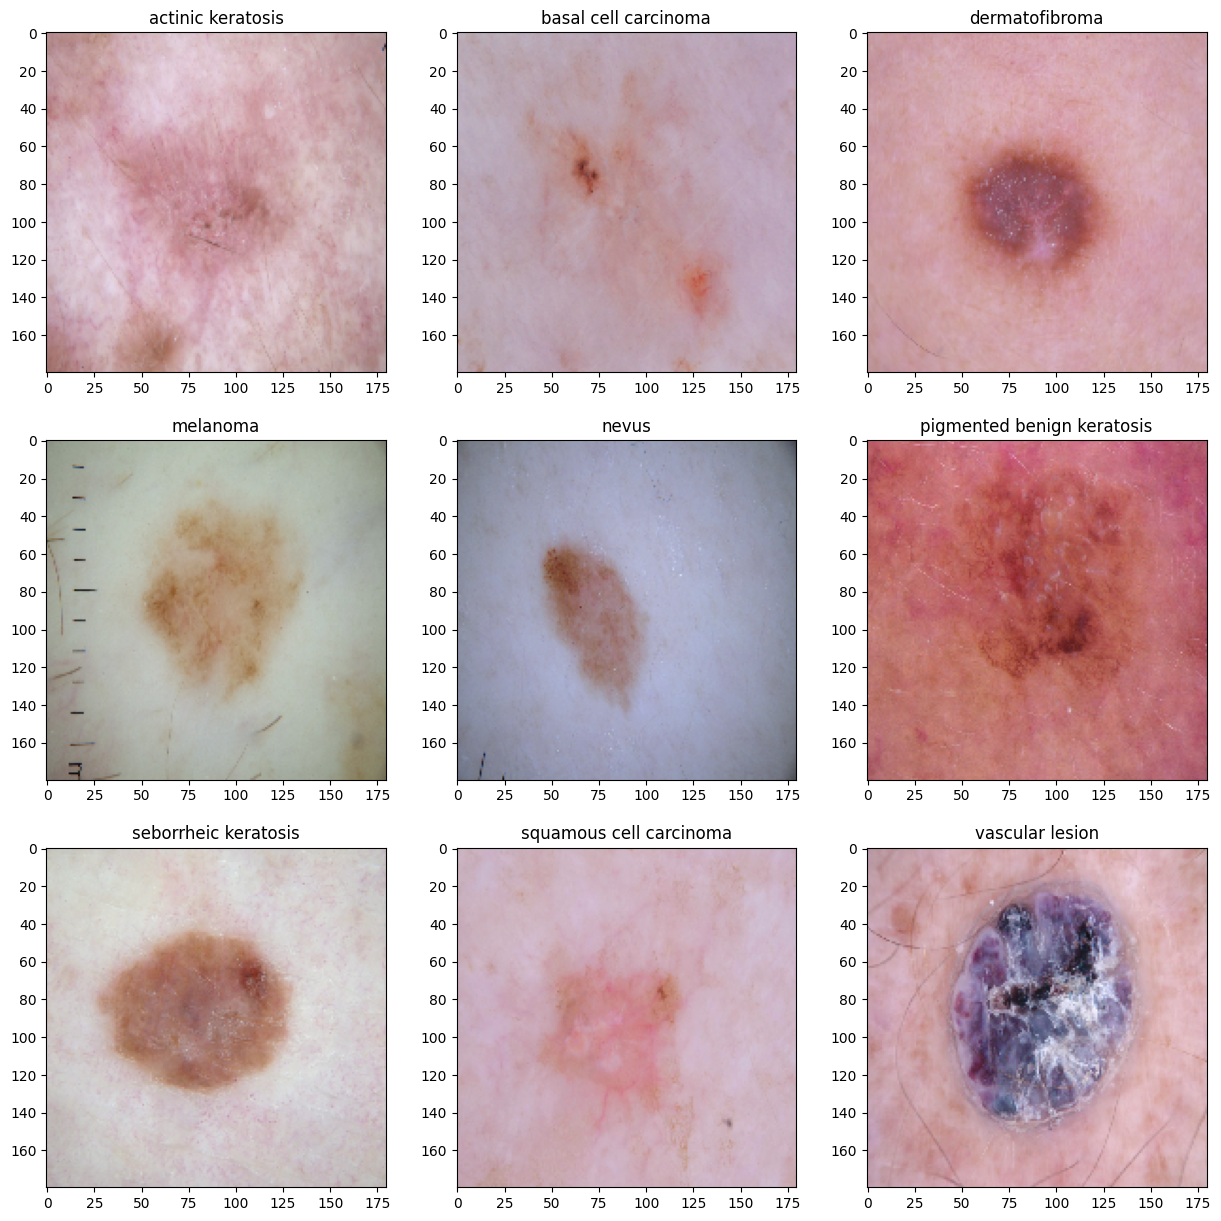

In [12]:
import matplotlib.pyplot as plt

img_path = {}

for cnam in class_names:
    img_path[cnam] = list(map(lambda x:str(data_dir_train)+'/'+cnam+'/'+x,os.listdir(str(data_dir_train)+'/'+cnam)))

print(img_path)

plt.figure(figsize=(15,15))
i = 0
for cnam in class_names:
    path_list = img_path[cnam][:1]
    i += 1
    plt.subplot(3,3,i)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(cnam)


### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here
num_classes=9
model=Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

### Train the model

In [17]:
epochs = 20
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/20
56/56 [==============================] - 30s 120ms/step - loss: 1.9612 - accuracy: 0.2690 - val_loss: 1.7083 - val_accuracy: 0.3915
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.5885 - accuracy: 0.4554 - val_loss: 1.4465 - val_accuracy: 0.5123
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3888 - accuracy: 0.5201 - val_loss: 1.4063 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 2s 36ms/step - loss: 1.3687 - accuracy: 0.5145 - val_loss: 1.3962 - val_accuracy: 0.5615
Epoch 5/20
56/56 [==============================] - 2s 36ms/step - loss: 1.2126 - accuracy: 0.5703 - val_loss: 1.4385 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.1593 - accuracy: 0.5882 - val_loss: 1.3448 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 2s 36ms/step - loss: 1.0526 - accuracy: 0.6177 - val_loss: 1.4215 - val_accuracy: 0.5257
Epoch 8/20


### Visualizing training results

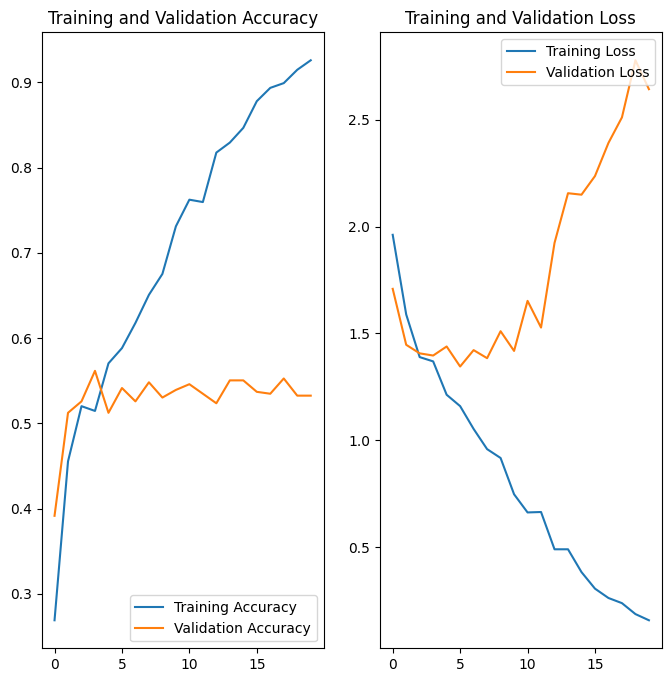

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

## From the above graph we can see that the Training Accuracy is fine but Validation Accuracy is very low. This infers that model is overfitting.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)])

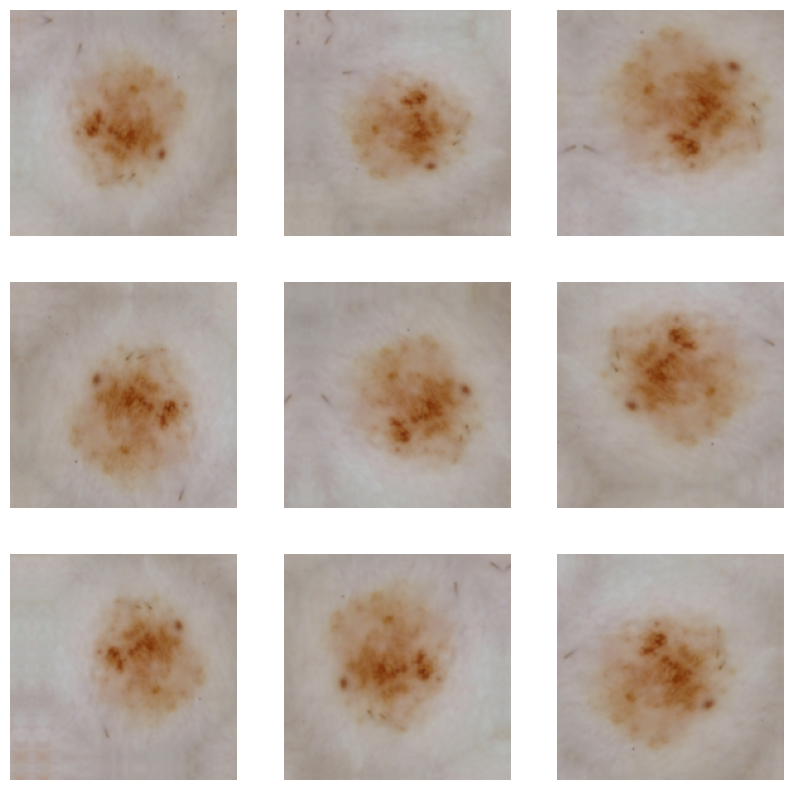

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for x in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, x + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off") 

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model2 = Sequential()                     
model2.add(data_augmentation)             
model2.add(tf.keras.Sequential([  layers.experimental.preprocessing.Rescaling(1./255)]))                       
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512,activation='relu'))
model2.add(layers.Dense(128,activation='relu'))
model2.add(layers.Dropout(0.50))
model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [22]:
## Your code goes here
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)
## your training code

Epoch 1/20
56/56 [==============================] - 8s 73ms/step - loss: 2.3574 - accuracy: 0.1914 - val_loss: 2.0426 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 1.9739 - accuracy: 0.2321 - val_loss: 1.8302 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 3s 60ms/step - loss: 1.8336 - accuracy: 0.3276 - val_loss: 1.7620 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.7520 - accuracy: 0.3583 - val_loss: 1.7675 - val_accuracy: 0.3468
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 1.7273 - accuracy: 0.3532 - val_loss: 1.7053 - val_accuracy: 0.3647
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.6852 - accuracy: 0.3756 - val_loss: 1.5884 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 3s 59ms/step - loss: 1.6389 - accuracy: 0.4012 - val_loss: 1.5815 - val_accuracy: 0.4251
Epoch 8/20
56

### Visualizing the results

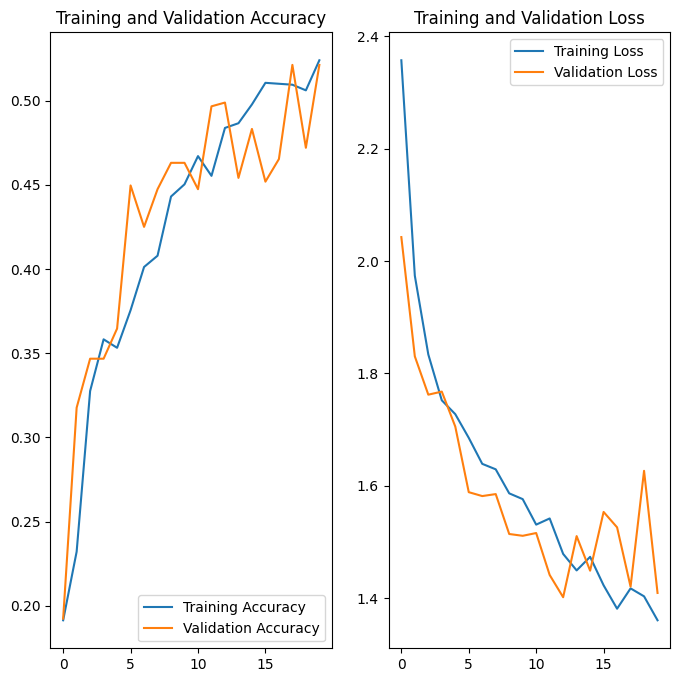

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## After Augumentation, the overfitting problem is resolved
## The problem of underfitting is still present

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
## Your code goes here.
count= []
for path in pathlib.Path(data_dir_train).iterdir():
    if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                           if os.path.isfile(os.path.join(path, name))]))
    
sub_directory = [name for name in os.listdir(data_dir_train)
                if os.path.isdir(os.path.join(data_dir_train, name))]
    
clas_img_df= pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])
clas_img_df

,Class,No. of Image
0,seborrheic keratosis,77
1,actinic keratosis,114
2,dermatofibroma,95
3,squamous cell carcinoma,181
4,melanoma,438
5,pigmented benign keratosis,462
6,vascular lesion,139
7,basal cell carcinoma,376
8,nevus,357


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
# seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
# pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F83F01A2CB0>: 100%|██████████| 500/500 [00:24<00:00, 20.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8380237D90>: 100%|██████████| 500/500 [00:27<00:00, 18.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F83F0AECF40>: 100%|██████████| 500/500 [00:23<00:00, 21.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8410093940>: 100%|██████████| 500/500 [01:49<00:00,  4.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F840B949C30>: 100%|██████████| 500/500 [01:41<00:00,  4.91 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8412017610>: 100%|██████████| 500/500 [00:20<00:00, 23.95 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8408A18670>: 100%|██████████| 500/500 [00:47<00:00, 10.54 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F83F0B753F0>: 100%|██████████| 500/500 [00:18<00:00, 26.67 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F83F016A950>: 100%|██████████| 500/500 [00:19<00:00, 25.62 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
# image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
# print(image_count_train)

### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010909.jpg_bfc03ffc-cbeb-4e2b-a376-f3cd57d43431.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011057.jpg_b9f8e840-a691-448b-8daf-ffcdfd657df2.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010925.jpg_840d4467-d0de-4127-a38b-983ed4c8d84a.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011136.jpg_fbbd05c4-ff05-47a0-b6ea-0ca4d2201251.jpg',
 '/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011193.jpg_2c22e8d3-287a-4a2b-9dd0-c50fc531ef63.jpg',
 '/dataset/Skin

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
cls_img_df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [33]:
cls_img_df2['Label'].value_counts()

seborrheic keratosis          500
actinic keratosis             500
dermatofibroma                500
squamous cell carcinoma       500
melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
basal cell carcinoma          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
## your code goes here
num_classes=9
model3=Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model3.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)# your model fit code

Epoch 1/30
169/169 [==============================] - 52s 277ms/step - loss: 1.9256 - accuracy: 0.2574 - val_loss: 1.5630 - val_accuracy: 0.4031
Epoch 2/30
169/169 [==============================] - 32s 183ms/step - loss: 1.5219 - accuracy: 0.4184 - val_loss: 1.3349 - val_accuracy: 0.5204
Epoch 3/30
169/169 [==============================] - 36s 205ms/step - loss: 1.3562 - accuracy: 0.4746 - val_loss: 1.2234 - val_accuracy: 0.5056
Epoch 4/30
169/169 [==============================] - 33s 193ms/step - loss: 1.2446 - accuracy: 0.5313 - val_loss: 1.1774 - val_accuracy: 0.5716
Epoch 5/30
169/169 [==============================] - 31s 182ms/step - loss: 1.0369 - accuracy: 0.6061 - val_loss: 1.1452 - val_accuracy: 0.5902
Epoch 6/30
169/169 [==============================] - 31s 180ms/step - loss: 0.8215 - accuracy: 0.6955 - val_loss: 0.8459 - val_accuracy: 0.6837
Epoch 7/30
169/169 [==============================] - 33s 186ms/step - loss: 0.6751 - accuracy: 0.7435 - val_loss: 0.7412 - val_ac

#### **Todo:**  Visualize the model results

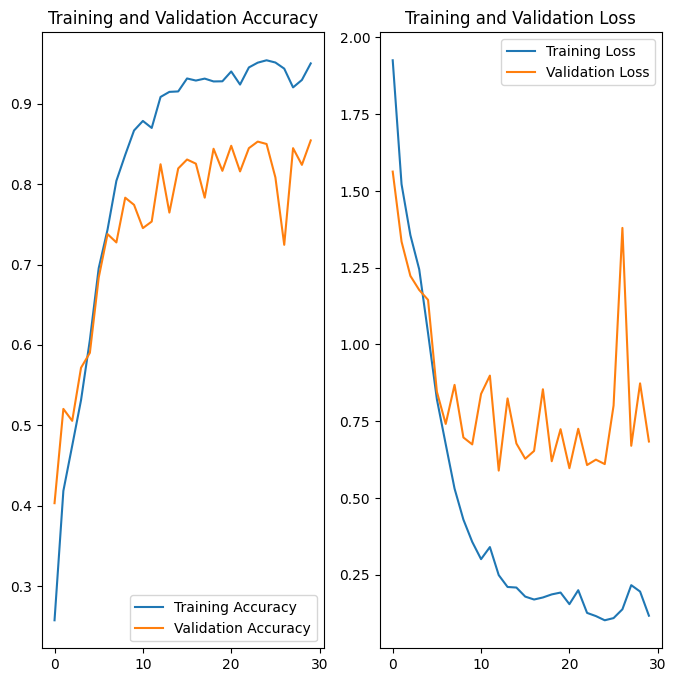

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



## From the above graph, we can see that the Accuracy of Train and Validation have improved significantly.
#### Train accuracy=95.03%, Validation accuracy=85.45%